<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [ ]:
!pip install opencv-python

In [1]:
DATA_PATH = ''
%matplotlib inline

# For Google Colab only:
# import sys
# sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
#from reco_utils.recommender.sar.sar_singlenode import SARSingleNode
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
!cp '/content/gdrive/MyDrive/Image Captioning/beheaded_inception3.py' ./
!cp '/content/gdrive/MyDrive/Image Captioning/handout.tar' ./
!tar -xf /content/handout.tar

In [85]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load("./data/image_codes.npy")
captions = json.load(open('./data/captions_tokenized.json'))

In [86]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:
ВАЖНО! Почему я советую писать отдельную функцию, которая генерирует батч: дело в том, что в датасете для каждой картинки есть несколько (5-7) различных описаний. Когда создаете батч, лучше, чтобы в нем были разные картинки, и к каждой картинке при создании батча выбирать одно из ее описаний рандомно. Это проще реализовать в отдельной функции (но вы, конечно, можете писать код как хотите)
5. Поделить выборку на train/test

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [87]:
import copy
START = "<START>"
END = "<END>"
PAD = "<PAD>"
UNK = "<UNK>"
captions_processed = copy.deepcopy(captions)
for img_captions in range(len(captions)):
    for caption in range(len(captions[img_captions])):
        sentence = captions[img_captions][caption] 
        captions_processed[img_captions][caption] = [START]+sentence.split(' ')+[END]

In [88]:
from collections import Counter
word_counts = Counter()

for img_captions in range(len(captions_processed)):
    for caption in range(len(captions_processed[img_captions])):
        for word in captions_processed[img_captions][caption][1:-1]:
          word_counts[word] += 1

In [89]:
vocab = []
vocab = [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
vocab += [UNK, START, END, PAD]
tokens_length = len(vocab)

word_to_index = {w: i for i, w in enumerate(vocab)}

In [111]:
len(vocab)

10403

In [90]:
eos_ix = word_to_index[END]
unk_ix = word_to_index[UNK]
pad_ix = word_to_index[PAD]

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [91]:
as_matrix(captions_processed[2545])

array([[10400,    20,   117,   118,    54,    20,   439,  3305,  1658,
        10401, 10402, 10402, 10402, 10402],
       [10400,    20,   127,    43,   117,    54,    20,  4806,   326,
          118,     8, 10401, 10402, 10402],
       [10400,  3698,    11,   769,   118,   137,    10,    20,   117,
        10401, 10402, 10402, 10402, 10402],
       [10400,    20,    43,   118,   136,     2,    20,   117,   370,
           20,  3601,    98,     8, 10401],
       [10400,    41,   117,    37,   769,    11,   620,   113,   512,
         1853,     8, 10401, 10402, 10402]], dtype=int32)

In [92]:
from random import choice
import torch, torch.nn as nn
import torch.nn.functional as F

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    batch_images = img_codes[random_image_ix]
    captions_for_batch_images = captions[random_image_ix]
    
    batch_captions = list(map(choice,captions_for_batch_images))
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)

In [94]:
from sklearn.model_selection import train_test_split

captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions, test_size=0.15, random_state=24)

### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [95]:
class CaptionNet(nn.Module):
    def __init__(self, cnn_feature_size=2048, lstm_feature_size=256, emb_size=128, tokens_size=0):
        super(self.__class__, self).__init__()

        # стандартная архитектура такой сети такая: 
        # 1. линейные слои для преобразования эмбеддиинга картинки в начальные состояния h0 и c0 LSTM-ки
        self.cnn_h0 = nn.Linear(cnn_feature_size, lstm_feature_size)
        self.cnn_c0 = nn.Linear(cnn_feature_size, lstm_feature_size)

        # 2. слой эмбедднга
        self.emb = nn.Embedding(tokens_size, emb_size, padding_idx = pad_ix)

        # 3. несколько LSTM слоев (для начала не берите больше двух, чтобы долго не ждать)
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=lstm_feature_size, batch_first = True, num_layers=1)

        # 4. линейный слой для получения логитов
        self.logits = nn.Linear(lstm_feature_size, tokens_size)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержащий выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]

        Обратите внимание, что мы подаем сети на вход сразу все префиксы описания 
        и просим ее к каждому префиксу сгенерировать следующее слово!
        """
        
        # 1. инициализируем LSTM state
        initial_cell = self.cnn_c0(image_vectors)
        initial_hid = self.cnn_h0(image_vectors)
        # 2. применим слой эмбеддингов к image_vectors
        captions_emb = self.emb(captions_ix)
        # 3. скормим LSTM captions_emb
        lstm_out, _ = self.lstm(captions_emb, (initial_cell.unsqueeze(0), initial_hid.unsqueeze(0)))
        # 4. посчитаем логиты из выхода LSTM
        logits = self.logits(lstm_out)
        
        return logits        

In [101]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, word_i]. 
    
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """

    image_vectors = image_vectors.to(device)
    captions_ix = captions_ix.to(device)
    
    # реализуйте стандартный cross entropy loss: итоговый лосс есть сумма лоссов для каждого слова.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    mask = captions_ix_next != pad_ix 
    # 1. Получаем логиты, прогоняя image_vectors через сеть
    logits_for_next = network(image_vectors.to(device), captions_ix_inp)
    # 2. Вычисляем лосс-функцию между полученными логитами и captions_ix. Будьте внимательны: 
    # вычисляйте лосс между логитами, полученными из сети, и соответствующими им значениями из captions_ix!
    next_reshaped = captions_ix_next.view(-1)
    logits_reshaped = logits_for_next.view(-1, logits_for_next.size()[-1])
    
    # ВАЖНО: не забудтье, что PADDING не должен влиять на лосс -- лосс должен склыдваться
    # только из тех мест, где должно быть предсказано слово, а не PAD
    # это можно сделать либо заведя маску из нулей и единиц (captions_ix_next != pad_ix) и умножить на нее лосс,
    # либо просто используя ignore_index, который в торче есть как аргумент у некоторых лоссов.
    cross_entropy = nn.CrossEntropyLoss(reduction = 'none').to(device)
    loss = cross_entropy(logits_reshaped, next_reshaped).view(captions_ix_next.size()[0], captions_ix_next.size()[1]) * mask.float()
    
    return loss.mean(dim = -1).mean(dim = -1).view(-1)

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = CaptionNet(tokens_size=tokens_length).to(device)

optimizer = torch.optim.Adam(network.parameters(), lr=1e-3) # favourite one

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [103]:
batch_size = 128
n_epochs = 50
n_batches_per_epoch = 200
n_validation_batches = 10

In [104]:
from tqdm import tqdm

for epoch in range(n_epochs):
    network.train()
    train_loss = 0
    for _ in tqdm(range(n_batches_per_epoch)):
        
        img_batch, captions_batch = generate_batch(train_img_codes, train_captions, batch_size)
        loss_t = compute_loss(network, img_batch, captions_batch)
      
        loss_t.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss_t.cpu().data.numpy()[0]
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    network.eval()
    with torch.no_grad():
      for _ in range(n_validation_batches):
          loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
          val_loss += loss_t.cpu().data.numpy()[0]
      val_loss /= n_validation_batches
      print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch + 1, train_loss, val_loss))

100%|██████████| 200/200 [00:43<00:00,  4.64it/s]



Epoch: 1, train loss: 1.3631994765996933, val loss: 0.8676869153976441


100%|██████████| 200/200 [00:41<00:00,  4.76it/s]



Epoch: 2, train loss: 0.9776078481972218, val loss: 0.9078018248081208


100%|██████████| 200/200 [00:41<00:00,  4.82it/s]



Epoch: 3, train loss: 0.8823223896324635, val loss: 0.8644231915473938


100%|██████████| 200/200 [00:41<00:00,  4.81it/s]



Epoch: 4, train loss: 0.8103241193294525, val loss: 0.838287740945816


100%|██████████| 200/200 [00:42<00:00,  4.67it/s]



Epoch: 5, train loss: 0.7369451270997525, val loss: 0.6139731258153915


100%|██████████| 200/200 [00:43<00:00,  4.65it/s]



Epoch: 6, train loss: 0.6942234826087952, val loss: 0.6276540577411651


100%|██████████| 200/200 [00:42<00:00,  4.65it/s]



Epoch: 7, train loss: 0.6546954296529293, val loss: 0.6789121687412262


100%|██████████| 200/200 [00:42<00:00,  4.74it/s]



Epoch: 8, train loss: 0.6435314576327801, val loss: 0.6052850365638733


100%|██████████| 200/200 [00:40<00:00,  4.96it/s]



Epoch: 9, train loss: 0.6404279731214046, val loss: 0.596866112947464


100%|██████████| 200/200 [00:41<00:00,  4.79it/s]



Epoch: 10, train loss: 0.5999301369488239, val loss: 0.5879143953323365


100%|██████████| 200/200 [00:42<00:00,  4.74it/s]



Epoch: 11, train loss: 0.5796798740327358, val loss: 0.5398454606533051


100%|██████████| 200/200 [00:42<00:00,  4.67it/s]



Epoch: 12, train loss: 0.5582637204229832, val loss: 0.5619816511869431


100%|██████████| 200/200 [00:41<00:00,  4.81it/s]



Epoch: 13, train loss: 0.5626673436164856, val loss: 0.5776453137397766


100%|██████████| 200/200 [00:42<00:00,  4.73it/s]



Epoch: 14, train loss: 0.5471780641376972, val loss: 0.5256492316722869


100%|██████████| 200/200 [00:42<00:00,  4.75it/s]



Epoch: 15, train loss: 0.5415052487701177, val loss: 0.4952399879693985


100%|██████████| 200/200 [00:42<00:00,  4.71it/s]



Epoch: 16, train loss: 0.522911659553647, val loss: 0.5063085675239563


100%|██████████| 200/200 [00:42<00:00,  4.71it/s]



Epoch: 17, train loss: 0.5206451810896396, val loss: 0.5272682160139084


100%|██████████| 200/200 [00:41<00:00,  4.83it/s]



Epoch: 18, train loss: 0.5251817769557238, val loss: 0.503298643231392


100%|██████████| 200/200 [00:41<00:00,  4.78it/s]



Epoch: 19, train loss: 0.5111616750061512, val loss: 0.46373951286077497


100%|██████████| 200/200 [00:44<00:00,  4.54it/s]



Epoch: 20, train loss: 0.49238424248993395, val loss: 0.447559055685997


100%|██████████| 200/200 [00:42<00:00,  4.66it/s]



Epoch: 21, train loss: 0.4936658453196287, val loss: 0.49232153594493866


100%|██████████| 200/200 [00:42<00:00,  4.73it/s]



Epoch: 22, train loss: 0.4963045334070921, val loss: 0.461981888115406


100%|██████████| 200/200 [00:42<00:00,  4.66it/s]



Epoch: 23, train loss: 0.4905434825271368, val loss: 0.4979554623365402


100%|██████████| 200/200 [00:41<00:00,  4.77it/s]



Epoch: 24, train loss: 0.49042450323700904, val loss: 0.5143454879522323


100%|██████████| 200/200 [00:43<00:00,  4.59it/s]



Epoch: 25, train loss: 0.47799555912613867, val loss: 0.5068233862519265


100%|██████████| 200/200 [00:42<00:00,  4.72it/s]



Epoch: 26, train loss: 0.4793887846916914, val loss: 0.4726597607135773


100%|██████████| 200/200 [00:43<00:00,  4.60it/s]



Epoch: 27, train loss: 0.46872433058917523, val loss: 0.521724459528923


100%|██████████| 200/200 [00:43<00:00,  4.56it/s]



Epoch: 28, train loss: 0.45936277858912944, val loss: 0.4916479170322418


100%|██████████| 200/200 [00:43<00:00,  4.64it/s]



Epoch: 29, train loss: 0.46808583535254, val loss: 0.4728463262319565


100%|██████████| 200/200 [00:40<00:00,  4.94it/s]



Epoch: 30, train loss: 0.4842484753578901, val loss: 0.4708836764097214


100%|██████████| 200/200 [00:41<00:00,  4.79it/s]



Epoch: 31, train loss: 0.47371746599674225, val loss: 0.48352739214897156


100%|██████████| 200/200 [00:43<00:00,  4.56it/s]



Epoch: 32, train loss: 0.45311769500374793, val loss: 0.4577840119600296


100%|██████████| 200/200 [00:41<00:00,  4.86it/s]



Epoch: 33, train loss: 0.4722113698720932, val loss: 0.442025700211525


100%|██████████| 200/200 [00:43<00:00,  4.59it/s]



Epoch: 34, train loss: 0.451822447180748, val loss: 0.4762964189052582


100%|██████████| 200/200 [00:41<00:00,  4.82it/s]



Epoch: 35, train loss: 0.4674301441013813, val loss: 0.434811045229435


100%|██████████| 200/200 [00:41<00:00,  4.81it/s]



Epoch: 36, train loss: 0.4607468734681606, val loss: 0.43880348801612856


100%|██████████| 200/200 [00:40<00:00,  4.88it/s]



Epoch: 37, train loss: 0.46447269052267076, val loss: 0.4549870103597641


100%|██████████| 200/200 [00:42<00:00,  4.71it/s]



Epoch: 38, train loss: 0.45063738361001016, val loss: 0.44443455934524534


100%|██████████| 200/200 [00:42<00:00,  4.72it/s]



Epoch: 39, train loss: 0.44959819942712786, val loss: 0.4436980277299881


100%|██████████| 200/200 [00:43<00:00,  4.61it/s]



Epoch: 40, train loss: 0.44517390713095667, val loss: 0.4607793003320694


100%|██████████| 200/200 [00:42<00:00,  4.67it/s]



Epoch: 41, train loss: 0.4448492924869061, val loss: 0.4761110544204712


100%|██████████| 200/200 [00:44<00:00,  4.54it/s]



Epoch: 42, train loss: 0.4327822460979223, val loss: 0.4798104494810104


100%|██████████| 200/200 [00:41<00:00,  4.81it/s]



Epoch: 43, train loss: 0.45297010272741317, val loss: 0.44502111673355105


100%|██████████| 200/200 [00:42<00:00,  4.69it/s]



Epoch: 44, train loss: 0.4429991182684898, val loss: 0.44768764078617096


100%|██████████| 200/200 [00:43<00:00,  4.60it/s]



Epoch: 45, train loss: 0.4356549671292305, val loss: 0.45370376110076904


100%|██████████| 200/200 [00:42<00:00,  4.70it/s]



Epoch: 46, train loss: 0.4416919639706612, val loss: 0.43970770835876466


100%|██████████| 200/200 [00:43<00:00,  4.65it/s]



Epoch: 47, train loss: 0.439473395422101, val loss: 0.3807951048016548


100%|██████████| 200/200 [00:43<00:00,  4.57it/s]



Epoch: 48, train loss: 0.42626087114214894, val loss: 0.4298512369394302


100%|██████████| 200/200 [00:42<00:00,  4.69it/s]



Epoch: 49, train loss: 0.4334040887653828, val loss: 0.4641838401556015


100%|██████████| 200/200 [00:42<00:00,  4.75it/s]



Epoch: 50, train loss: 0.4384789832681417, val loss: 0.4583523213863373


## Inseption и получение результатов


In [123]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:83: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


### Сгенерируем описание

In [113]:
def generate_caption(image, caption_prefix=(START,), 
                     t=4, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        # слово за словом генерируем описание картинки
        for _ in range(max_len):
            # 1. представляем caption_prefix в виде матрицы
            caption_prefix_matrix = as_matrix([caption_prefix])
            caption_prefix_matrix = torch.tensor(caption_prefix_matrix, dtype=torch.int64)
            # 2. Получить из RNN-ки логиты, передав ей vectors_neck и матрицу из п.1
            logits = network(vectors_neck.to(device), caption_prefix_matrix.to(device))[0, -1]
            # 3. Перевести логиты RNN-ки в вероятности (например, с помощью F.softmax)
            probs = F.softmax(logits, dim=-1).cpu().numpy()
            # 4. сэмплировать следующее слово в описании, используя полученные вероятности. Можно сэмплировать жадно 
            # (тупо слово с самой большой вероятностью), можно сэмплировать из распределения
            probs = probs**t/np.sum(probs**t)

            if sample:
              word = np.random.choice(vocab, p=probs) 
            else:
              word = vocab[np.argmax(probs)]

            # 5. Добавляем новое слово в caption_prefix
            caption_prefix.append(word)
            # 6. Если RNN-ка сгенерила символ конца предложения, останавливаемся
            if caption_prefix == END:
              break
            
    return caption_prefix

### Скачаем пару картинок, чтобы проверить качество:

In [114]:
from matplotlib import pyplot as plt
# from scipy.misc import imresize
import cv2
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(img, (299, 299)).astype('float32') / 255.

--2022-02-12 19:36:25--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2022-02-12 19:36:26--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.01s   

2022-02-12 19:36:26 (5.23 MB/s) - ‘img.jpg’ saved [54731

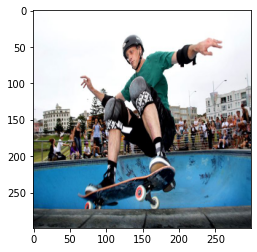

In [115]:
plt.imshow(img)

In [128]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5., sample=True)[1:-1]))

a n <UNK> s t a n d i n g <UNK> i n <UNK> a <UNK> b l u e <UNK> s h i r t <UNK> a n d <UNK> a <UNK> c a t <UNK> i s <UNK> s i t t i n g <UNK> o n <UNK> a <UNK> t a b l e <UNK> . . <UNK> a n d <UNK> a <UNK> c o m p u t e r <UNK> . . <UNK> a <UNK> c o u n t e r <UNK> . . <UNK> a n <UNK> o p
o m e <UNK> p e o p l e <UNK> s i t t i n g <UNK> o n <UNK> a <UNK> s t r e e t <UNK> s i g n <UNK> . <UNK> h i l l <UNK> . . <UNK> a <UNK> c o u n t e r <UNK> . <UNK> " <UNK> s i n k <UNK> . <UNK> " <UNK> . <UNK> " <UNK> w i t h <UNK> a <UNK> c l o c k <UNK> t o w e r <UNK> . . <UNK> a <UNK> c o
a n <UNK> s i t t i n g <UNK> o n <UNK> a <UNK> c o u c h <UNK> w i t h <UNK> a <UNK> b l u e <UNK> t a b l e <UNK> . <UNK> a <UNK> s i n k <UNK> . <UNK> " <UNK> w i t h <UNK> a <UNK> s t o p <UNK> s i g n <UNK> . <UNK> " <UNK> w i t h <UNK> a <UNK> w o o d e n <UNK> c o u n t e r <UNK> . <UNK> "
a n <UNK> w e a r i n g <UNK> a <UNK> p e r s o n <UNK> o n <UNK> a <UNK> s u r f b o a r d <UNK> o n <UNK> a <UNK

--2022-02-12 19:37:30--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 162.159.135.42
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2022-02-12 19:37:30--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img1.jpg’

img1.jpg            100%[===================>] 104.37K  --.-KB/s    in 0.1s    

2022-02-12 19:37:31 (792 KB/s) - ‘img1.jpg’ saved [106870/106870]



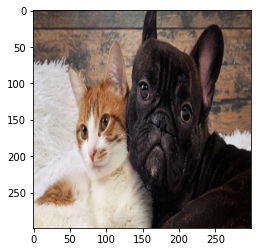

a l l <UNK> p l a y e r s <UNK> s i t t i n g <UNK> o n <UNK> a <UNK> b e a c h <UNK> w i t h <UNK> a <UNK> c a t <UNK> i n <UNK> a <UNK> p l a t e <UNK> . <UNK> " <UNK> s i n k <UNK> . <UNK> h i m <UNK> . . <UNK> a <UNK> w i n d o w <UNK> . . <UNK> a n <UNK> o p e n <UNK> f i e l d <UNK> . <UNK>
a s t <UNK> p a s s e n g e r <UNK> t r a i n <UNK> i s <UNK> s i t t i n g <UNK> o n <UNK> a <UNK> s t r e e t <UNK> . <UNK> " <UNK> w i t h <UNK> a <UNK> p l a t e <UNK> o f <UNK> f o o d <UNK> . <UNK> h i m <UNK> . . <UNK> a <UNK> c l o c k <UNK> o n <UNK> t h e <UNK> s t r e e t <UNK>
a t <UNK> s i t t i n g <UNK> o n <UNK> t o p <UNK> o f <UNK> a <UNK> b u i l d i n g <UNK> . <UNK> " <UNK> s i t t i n g <UNK> o n <UNK> a <UNK> t a b l e <UNK> . <UNK> " <UNK> f i l l e d <UNK> w i t h <UNK> a <UNK> p i e c e <UNK> o f <UNK> f o o d <UNK> . <UNK> " <UNK> . <UNK> " <UNK> f i r e
a l l <UNK> p l a y e r s <UNK> s i t t i n g <UNK> o n <UNK> a <UNK> s t o p <UNK> s i g n <UNK> . <UNK> " <UNK> 

In [118]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img1.jpg
img = plt.imread('img1.jpg')
img = cv2.resize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

--2022-02-12 19:37:44--  https://www.tensorflow.org/tutorials/text/image_captioning_files/output_9Psd1quzaAWg_2.png
Resolving www.tensorflow.org (www.tensorflow.org)... 209.85.145.100, 209.85.145.139, 209.85.145.138, ...
Connecting to www.tensorflow.org (www.tensorflow.org)|209.85.145.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 462356 (452K) [image/png]
Saving to: ‘img2.jpg’

img2.jpg            100%[===================>] 451.52K  --.-KB/s    in 0.004s  

2022-02-12 19:37:45 (100 MB/s) - ‘img2.jpg’ saved [462356/462356]



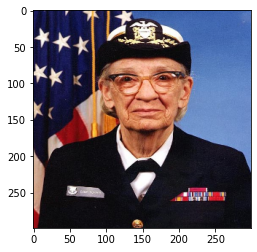

a n <UNK> s t a n d i n g <UNK> o n <UNK> a <UNK> c o u c h <UNK> w i t h <UNK> a <UNK> b u i l d i n g <UNK> w i t h <UNK> a <UNK> b l u e <UNK> a n d <UNK> w h i t e <UNK> p l a t e <UNK> . <UNK> " <UNK> . <UNK> f o o d <UNK> . <UNK> " <UNK> w i t h <UNK> a <UNK> c a k e <UNK> . <UNK> " <UNK> w
a n <UNK> s t a n d i n g <UNK> i n <UNK> a <UNK> p l a n e <UNK> i s <UNK> s i t t i n g <UNK> o n <UNK> a <UNK> t a b l e <UNK> . <UNK> " <UNK> s i n k <UNK> . <UNK> h i m <UNK> . . <UNK> a <UNK> c o m p u t e r <UNK> . . <UNK> a <UNK> p l a n t <UNK> . <UNK> " <UNK> s i t t i n g <UNK> o n
a n <UNK> s t a n d i n g <UNK> o n <UNK> a <UNK> t a b l e <UNK> w i t h <UNK> a <UNK> c a t <UNK> l a y i n g <UNK> o n <UNK> a <UNK> t a b l e <UNK> . . <UNK> a n d <UNK> c h a i r <UNK> . . <UNK> a <UNK> c o u c h <UNK> . <UNK> c a r r y i n g <UNK> a <UNK> s t r e e t <UNK> . <UNK> "
a n <UNK> w e a r i n g <UNK> a <UNK> b l a c k <UNK> a n d <UNK> w h i t e <UNK> p h o t o <UNK> o f <UNK> a <UNK> l 

In [119]:
# apply your network on images you've found
!wget https://www.tensorflow.org/tutorials/text/image_captioning_files/output_9Psd1quzaAWg_2.png -O img2.jpg

img = plt.imread('img2.jpg')
img = cv2.resize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

## Бонус: Achtung

В качестве бонусного задания предлагается реализовать механизм attention в rnn-сети, которую мы писали в базовой части.